In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#core data lib
import pandas as pd
import pandasql as ps

In [3]:
#https://ourworldindata.org/
#https://github.com/owid/covid-19-data/tree/master/public/data/
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [4]:
#df.head(10) #continent

In [5]:
df = df.sort_values(by=['date'])
df = df.reset_index()

#datetime to int(Epoch)
df['date'] = pd.to_datetime(df['date'])
df['date'] = (pd.to_numeric(df['date'])/1000000000).astype(int)

#text to string
df['continent'] = df['continent'].astype(str)
df['location'] = df['location'].astype(str)

In [6]:
df2 = ps.sqldf('''
                select *
                from 
                (select date, continent, location,
                
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) last3days,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 8 PRECEDING AND 4 PRECEDING) last8_4days,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 16 PRECEDING AND 9 PRECEDING) last16_9days,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 32 PRECEDING AND 17 PRECEDING) last32_17days,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 64 PRECEDING AND 33 PRECEDING) last64_33days,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 128 PRECEDING AND 65 PRECEDING) last128_64days,
                
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING) - 
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 14 PRECEDING AND 8 PRECEDING) changes_7days,

                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 21 PRECEDING AND 14 PRECEDING) - 
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 28 PRECEDING AND 22 PRECEDING) changes_next7days,

                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 30 PRECEDING AND 1 PRECEDING) - 
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 60 PRECEDING AND 31 PRECEDING) changes_30days,
                
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 90 PRECEDING AND 1 PRECEDING) - 
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 180 PRECEDING AND 91 PRECEDING) changes_90days,
                
                new_cases
                from df
                where continent is not null and continent !='nan' and total_cases>0
                order by date, new_cases
                ) a
                where changes_90days is not null
                ''')
#where total_cases>0 and location='Russia'

In [7]:
#NaN to 0
df2['new_cases'] = df2['new_cases'].fillna(0)
#df2['last_90days'] = df2['last_90days'].fillna(0)
#df2['last_30days'] = df2['last_30days'].fillna(0)

df2#.tail(8)
#332584

,date,continent,location,last3days,last8_4days,last16_9days,last32_17days,last64_33days,last128_64days,changes_7days,changes_next7days,changes_30days,changes_90days,new_cases
0,1587600000,Asia,Macao,0.0,0.0,1.0,26.0,8.0,9.0,0.0,-7.0,7.0,42.0,0.0
1,1587600000,Asia,Vietnam,0.0,2.0,21.0,151.0,78.0,16.0,-15.0,-40.0,38.0,264.0,0.0
2,1587600000,Asia,Taiwan,6.0,27.0,20.0,220.0,131.0,21.0,15.0,-43.0,62.0,425.0,1.0
3,1587600000,Asia,Hong Kong,8.0,13.0,98.0,641.0,211.0,62.0,-39.0,-94.0,400.0,1029.0,2.0
4,1587600000,Asia,Thailand,61.0,152.0,393.0,1809.0,376.0,31.0,-91.0,-185.0,1419.0,2822.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174628,1662854400,Asia,Taiwan,105054.0,169091.0,233604.0,364376.0,751836.0,3793665.0,27596.0,47561.0,133357.0,-113135.0,32105.0
174629,1662854400,Asia,Turkey,0.0,45882.0,80020.0,376031.0,1115373.0,141949.0,-34138.0,-376031.0,-613440.0,1217447.0,32191.0
174630,1662854400,Asia,South Korea,140327.0,367512.0,694063.0,1957012.0,2354538.0,1026653.0,-149679.0,-97744.0,383316.0,-5225139.0,36938.0
174631,1662854400,Europe,Russia,154012.0,224602.0,358768.0,511234.0,287945.0,240378.0,10196.0,101872.0,875390.0,630778.0,52155.0


In [8]:
#from sklearn.model_selection import train_test_split
#df_valid, df_test = train_test_split(df2, test_size=0.2)

df_train=df2.sample(frac=0.99,random_state=20220912) #random state is a seed value
df_valid=df2.drop(df_train.index)


# Initialize data
cat_features = [0, 1]

#train
Y_train = df_train['new_cases'] #df2['new_cases'].head(int(len(df2.index)*0.9))
X_train = df_train.drop(['new_cases', 'date'], axis=1) #df2.drop(['new_cases', 'date'], axis=1).head(int(len(df2.index)*0.9))

from catboost import Pool
train_pool= Pool(X_train, Y_train, cat_features)

#validation
Y_valid = df_valid['new_cases'] #df2['new_cases'].tail(int(len(df2.index)*0.1))
X_valid = df_valid.drop(['new_cases', 'date'], axis=1) #df2.drop(['new_cases', 'date'], axis=1).tail(int(len(df2.index)*0.1))


In [9]:
#import catboost
from catboost import CatBoostRegressor

#limits
limit_iterations = 20000
limit_metric_period = int(limit_iterations/50)
limit_early_stopping_rounds = int(limit_iterations*0.3)


# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=limit_iterations,
                          learning_rate=0.4,
                          depth=12,
                          #task_type="GPU",
                          #devices='0:1'
                          thread_count = 16,
                          #loss_function="RMSE",
                          #eval_metric="RMSE",
                          #остановка переобучения после нахождения оптимального дерева
                          early_stopping_rounds=limit_early_stopping_rounds
                         )
# Fit model
model.fit(train_pool, eval_set=(X_valid, Y_valid), metric_period=limit_metric_period) #, plot='true'


0:	learn: 14005.1888284	test: 9270.3426186	best: 9270.3426186 (0)	total: 216ms	remaining: 1h 11m 56s
400:	learn: 1716.1953264	test: 4653.9668927	best: 4644.7258532 (393)	total: 37.7s	remaining: 30m 42s
800:	learn: 1281.5889649	test: 4634.5046077	best: 4611.5569394 (503)	total: 1m 15s	remaining: 30m 9s
1200:	learn: 1033.2812418	test: 4634.8068108	best: 4611.5569394 (503)	total: 1m 53s	remaining: 29m 35s
1600:	learn: 971.3211898	test: 4636.8117342	best: 4611.5569394 (503)	total: 2m 31s	remaining: 29m 1s
2000:	learn: 938.6093517	test: 4644.4954051	best: 4611.5569394 (503)	total: 3m 9s	remaining: 28m 27s
2400:	learn: 911.0580356	test: 4649.7720688	best: 4611.5569394 (503)	total: 3m 48s	remaining: 27m 51s
2800:	learn: 702.2078496	test: 4647.6476672	best: 4611.5569394 (503)	total: 4m 25s	remaining: 27m 12s
3200:	learn: 691.7500203	test: 4652.3535759	best: 4611.5569394 (503)	total: 5m 4s	remaining: 26m 36s
3600:	learn: 633.3547941	test: 4654.8295652	best: 4611.5569394 (503)	total: 5m 42s	rema

In [ ]:
#цикл
i=0
while i < 90:
    i = i + 1

    #данные для предсказания
    df_predict = ps.sqldf('''
                    select *
                    from
                    (select date as date, continent, location,
                    
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 3-1 PRECEDING AND 1-1 PRECEDING) last3days,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 8-1 PRECEDING AND 4-1 PRECEDING) last8_4days,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 16-1 PRECEDING AND 9-1 PRECEDING) last16_9days,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 32-1 PRECEDING AND 17-1 PRECEDING) last32_17days,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 64-1 PRECEDING AND 33-1 PRECEDING) last64_33days,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 128-1 PRECEDING AND 65-1 PRECEDING) last128_64days,
                   
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7-1 PRECEDING AND 1-1 PRECEDING) - 
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 14-1 PRECEDING AND 8-1 PRECEDING) changes_7days,

                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 21-1 PRECEDING AND 14-1 PRECEDING) - 
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 28-1 PRECEDING AND 22-1 PRECEDING) changes_next7days,

                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 30-1 PRECEDING AND 1-1 PRECEDING) - 
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 60-1 PRECEDING AND 31-1 PRECEDING) changes_30days,
                    
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 90-1 PRECEDING AND 1-1 PRECEDING) - 
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 180-1 PRECEDING AND 91-1 PRECEDING) changes_90days
                    
                    from df2
                    order by date, new_cases) a
                    where date=(select max(date) from df2)
                        and location='Russia'
                    ''')
    df_predict

    #предсказание
    preds = model.predict(df_predict.loc[:, df_predict.columns !='date'], thread_count = 16)
    #preds

    #возвращаем рассчитанные значения
    df_new_row = df_predict
    df_new_row = df_new_row.join(pd.DataFrame(preds))
    df_new_row.rename(columns={0: 'new_cases'}, inplace=True)
    df_new_row['date'] = df_new_row['date']+86400
    df_new_row['new_cases'] = df_new_row['new_cases'].astype(int)
    #df_new_row

    #возвращает данные в основной массив
    df2 = pd.concat([df2, df_new_row], axis=0, ignore_index=True)
    #df2

#df2.tail(10)

In [ ]:
import plotly.express as px

#df2['date'] = pd.to_datetime(df2['date'])

df2graphe = ps.sqldf('''select * from df2 where location='Russia' order by date, new_cases ''')
df2graphe['date'] = pd.to_datetime(df2graphe['date'],unit='s')

fig = px.line(df2graphe, x="date", y="new_cases", title='covid stats')
fig.show()

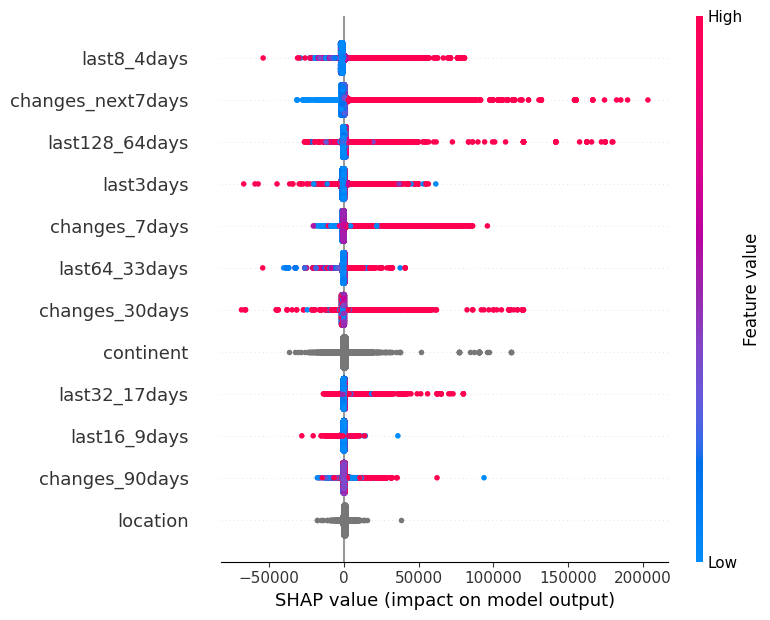

In [12]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)

shap.summary_plot(shap_values, X_train)

In [13]:
#shap.summary_plot(shap_values, X_train, plot_type="bar")